We need GPU for it because Section 1.2 will be very slow. So we go to **"Runtime"** option of Colab and **Change Runtime Type** to **GPU**. Then we check if it's enabled.

In [11]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# 5.3
There are two ways to use a pretrained network: <br>
- feature extraction
- fine-tuning

## 1. Feature Extraction

In [1]:
# VGG16 Model
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 2s 0us/step


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

We will use two methods

### 1.1. Fast Feature Extraction without Data Augmentation

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [4]:
# Fetch the path of dataset.
base_dir = "/content/drive/My Drive/Colab_Notebooks/dog-cat-small"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [6]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
                directory,
                target_size=(150, 150),
                batch_size=batch_size,
                class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break # because generators yield data indefinitely in a loop,
                  # we must break after every image has been seen once.
    
    return features, labels

In [7]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)
# it took about 1hour

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512). we will feed them
to a densely connected classifier, so first you must flatten them to (samples, 8192):

In [8]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### Train

In [9]:
#Defining and training the densely connected classifier
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
            loss='binary_crossentropy',
            metrics=['acc'])

history = model.fit(train_features, train_labels,
            epochs=30,
            batch_size=20,
            validation_data=(validation_features, validation_labels))

# it took only some seconds, as we have to deal with only 2 dense layers

Epoch 1/30
100/100 [==============================] - 1s 7ms/step - loss: 0.5994 - acc: 0.6755 - val_loss: 0.4331 - val_acc: 0.8250
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.4135 - acc: 0.8050 - val_loss: 0.3516 - val_acc: 0.8620
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3524 - acc: 0.8555 - val_loss: 0.3146 - val_acc: 0.8770
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3170 - acc: 0.8700 - val_loss: 0.2917 - val_acc: 0.8850
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2873 - acc: 0.8860 - val_loss: 0.2775 - val_acc: 0.8860
Epoch 6/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2575 - acc: 0.8990 - val_loss: 0.2675 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2395 - acc: 0.9040 - val_loss: 0.2597 - val_acc: 0.8950
Epoch 8/30
100/100 [==============================] - 1s 5ms/step - loss: 0.

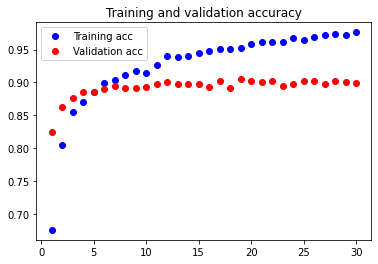

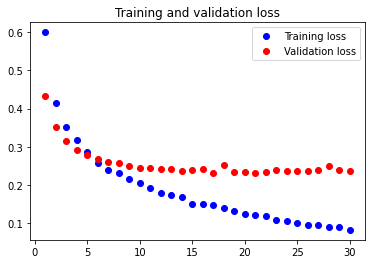

In [10]:
# plotting result
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Again Overfitting as we aren't using Data Augmentation here. So now we will try that.
### 1.2. FEATURE EXTRACTION WITH DATA AUGMENTATION

We must do it with GPU as mentioned at the start of this notebook.

In [12]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


<h3>Note:</h3>Before we compile and train the model, it’s very important to freeze the convolutional
base. 

**Freezing a layer or set of layers means preventing their weights from being updated during training.**
If you don’t do this, then the representations that were previously
learned by the convolutional base will be modified during training. Because
the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In [15]:
import pandas as pd
print("Before freeze, number of trainable weights:", len(model.trainable_weights))
conv_base.trainable = False
print("After freeze:", len(model.trainable_weights))

Before freeze, number of trainable weights: 30
After freeze: 4


### Train

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(150, 150),
                    batch_size=20,
                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
                            validation_dir,
                            target_size=(150, 150),
                            batch_size=20,
                            class_mode='binary')
model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=2e-5),
                metrics=['acc'])
history = model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 [==============================] - 30s 300ms/step - loss: 0.6004 - acc: 0.6765 - val_loss: 0.4607 - val_acc: 0.8180
Epoch 2/30
100/100 [==============================] - 29s 291ms/step - loss: 0.4880 - acc: 0.7890 - val_loss: 0.3656 - val_acc: 0.8640
Epoch 3/30
100/100 [==============================] - 29s 292ms/step - loss: 0.4318 - acc: 0.8180 - val_loss: 0.3276 - val_acc: 0.8720
Epoch 4/30
100/100 [==============================] - 28s 284ms/step - loss: 0.3995 - acc: 0.8300 - val_loss: 0.3160 - val_acc: 0.8730
Epoch 5/30
100/100 [==============================] - 28s 283ms/step - loss: 0.3863 - acc: 0.8325 - val_loss: 0.2954 - val_acc: 0.8720
Epoch 6/30
100/100 [==============================] - 29s 287ms/step - loss: 0.3816 - acc: 0.8335 - val_loss: 0.2810 - val_acc: 0.8810
Epoch 7/30
100/100 [==========

In [17]:
model.save('cats_and_dogs_small_3.h5')

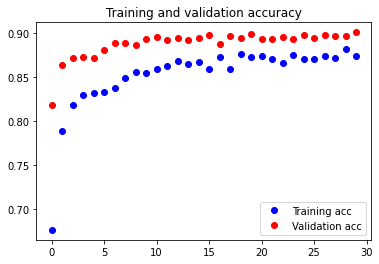

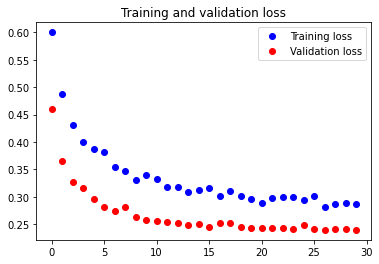

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 2. Fine Tuning
It’s only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifier isn’t already trained, then the error signal
propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus the steps for fine-tuning a network are as follow:
- Add your custom network on top of an already-trained base network.
- Freeze the base network.
- Train the part you added.
- Unfreeze some layers in the base network.
- Jointly train both these layers and the part you added.

We have done first 2steps! (yo hu!)

In [19]:
# we check our architechture again
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

We will fine-tune the last 3 convolutional layers, which means that all layers up until block4_pool should be frozen, and the layers block5_conv1, block5_conv2 and block5_conv3 should be trainable.

In [20]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### Train

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 31s 307ms/step - loss: 0.2957 - acc: 0.8725 - val_loss: 0.2132 - val_acc: 0.9120
Epoch 2/100
100/100 [==============================] - 30s 305ms/step - loss: 0.2481 - acc: 0.8905 - val_loss: 0.2155 - val_acc: 0.9130
Epoch 3/100
100/100 [==============================] - 31s 308ms/step - loss: 0.2369 - acc: 0.8975 - val_loss: 0.2062 - val_acc: 0.9150
Epoch 4/100
100/100 [==============================] - 31s 309ms/step - loss: 0.2064 - acc: 0.9185 - val_loss: 0.2102 - val_acc: 0.9150
Epoch 5/100
100/100 [==============================] - 31s 307ms/step - loss: 0.2186 - acc: 0.9060 - val_loss: 0.2362 - val_acc: 0.9060
Epoch 6/100
100/100 [==============================] - 31s 309ms/step - loss: 0.1886 - acc: 0.9215 - val_loss: 0.1908 - val_acc: 0.9300
Epoch 7/100
100/100 [==============================] - 31s 309ms/step - loss: 0.1761 - acc: 0.9255 - val_loss: 0.2007 - val_acc: 0.9230
Epoch 8/100
100/100 [===========================

In [22]:
model.save('cats_and_dogs_small_4.h5')

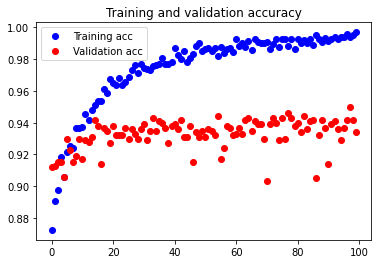

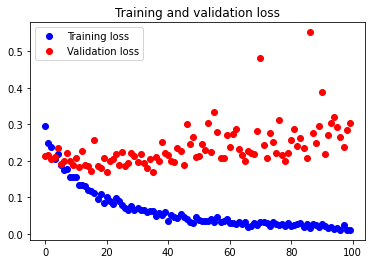

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can smooth this noise plot.

In [27]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

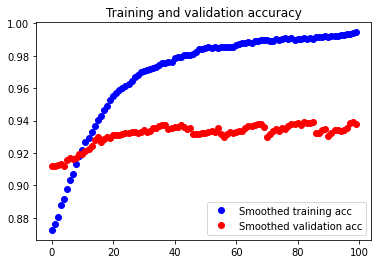

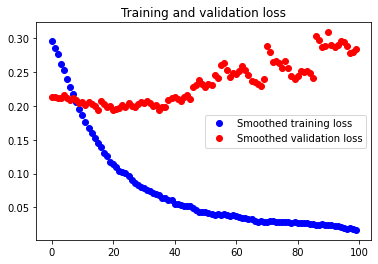

In [28]:
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'ro', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'ro', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


<h3>Question:</h3>
How could accuracy stay stable or improve if the loss isn’t
decreasing? 
<h3>Answer:</h3> What we display is an average of pointwise loss values;
but what matters for accuracy is the distribution of the loss values, not their average, because accuracy is the result of a binary thresholding of the class probability predicted by the model. The model may still be improving even if this isn’t reflected
in the average loss.

### Final Evaluation on test data

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)


## What we Learnt:
- Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very small dataset, with decent results.
- On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image data.
- It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with small image datasets.
- As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.